In [55]:
#from google.colab import drive
#drive.mount('/content/drive')

In [56]:
'''
import os
#os.chdir('/content/drive/MyDrive/EEG_LaPlata_Tandil_Project/notebooks')
path_files = '/content/drive/MyDrive/EEG_LaPlata_Tandil_Project/dataset/files'

os.chdir('/content/drive/.shortcut-targets-by-id/1U4taq5Q_GeO0egjJeAIq-PTceENP08bA/EEG_LaPlata_Tandil_Project/notebooks')

os.getcwd()
'''

"\nimport os\n#os.chdir('/content/drive/MyDrive/EEG_LaPlata_Tandil_Project/notebooks')\npath_files = '/content/drive/MyDrive/EEG_LaPlata_Tandil_Project/dataset/files'\n\nos.chdir('/content/drive/.shortcut-targets-by-id/1U4taq5Q_GeO0egjJeAIq-PTceENP08bA/EEG_LaPlata_Tandil_Project/notebooks')\n\nos.getcwd()\n"

In [57]:
import os

path_files = os.path.join(os.getcwd(), 'files')
os.getcwd()

'd:\\Facultad\\Doctorado\\Proyectos\\EEG'

In [58]:
#!pip install pyEDFlib # necesario para manejar archivos .edf

In [59]:
import importlib

import numpy as np
import random
import time
import pandas as pd
import os
import random
from tqdm import tqdm


# Signals
from scipy.stats import mannwhitneyu
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import welch
import scipy.signal

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


from matplotlib.colors import Normalize, LogNorm

import auxlib; importlib.reload(auxlib)

<module 'auxlib' from 'd:\\Facultad\\Doctorado\\Proyectos\\EEG\\auxlib.py'>

In [60]:
#path_files = '/content/drive/MyDrive/EEG_LaPlata_Tandil_Project/dataset/files'

# path for all users

#path_files = '/content/drive/.shortcut-targets-by-id/1U4taq5Q_GeO0egjJeAIq-PTceENP08bA/EEG_LaPlata_Tandil_Project/dataset/files'

# Importing data

In [61]:
def showEEG(signals, ti, tf, time, electrodes=[1, 2, 3, 4, 5, 6, 7, 8, 9]):
    t0_labels, t1_labels, t2_labels = task_labels(header)
    fig, axes = plt.subplots(len(electrodes), 1, figsize=(20, len(electrodes)), sharex=True)

    for ax, i in zip(axes, electrodes):
        ax.plot(time[ti:tf], signals[i][ti:tf], color='purple')

        # Remove axis frames and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])

        # Add channel label to the left
        ax.text(-0.02, 0.5, f'Ch {i+1}', transform=ax.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='right')
        for t1 in t1_labels:
            ax.axvline(x=t1, color='red')
        for t2 in t2_labels:
            ax.axvline(x=t2, color='blue')
        for t0 in t0_labels:
            ax.axvline(x=t0, color='black')
    # Show only the last x-axis
    axes[-1].spines['bottom'].set_visible(True)
    axes[-1].set_xlim(time[ti], time[tf-1])
    axes[-1].set_xticks(range(0, int((tf - ti)/160), max(1, (tf - ti) // 4800)))  # Adjust tick marks
    axes[-1].set_xlabel("Time (s)", fontsize=14)

    plt.subplots_adjust(left=0.05)  # Adjust layout to fit labels
    #plt.show()
    return fig

In [62]:
def task_labels(header):
	t0_labels = []
	t1_labels = []
	t2_labels = []
	for task in range(len(header['annotations'])):
		if header['annotations'][task][2] == 'T1':
			t1_labels.append(header['annotations'][task][0])
		elif header['annotations'][task][2] == 'T2':
			t2_labels.append(header['annotations'][task][0])
		else:
			t0_labels.append(header['annotations'][task][0])
	return t0_labels, t1_labels, t2_labels

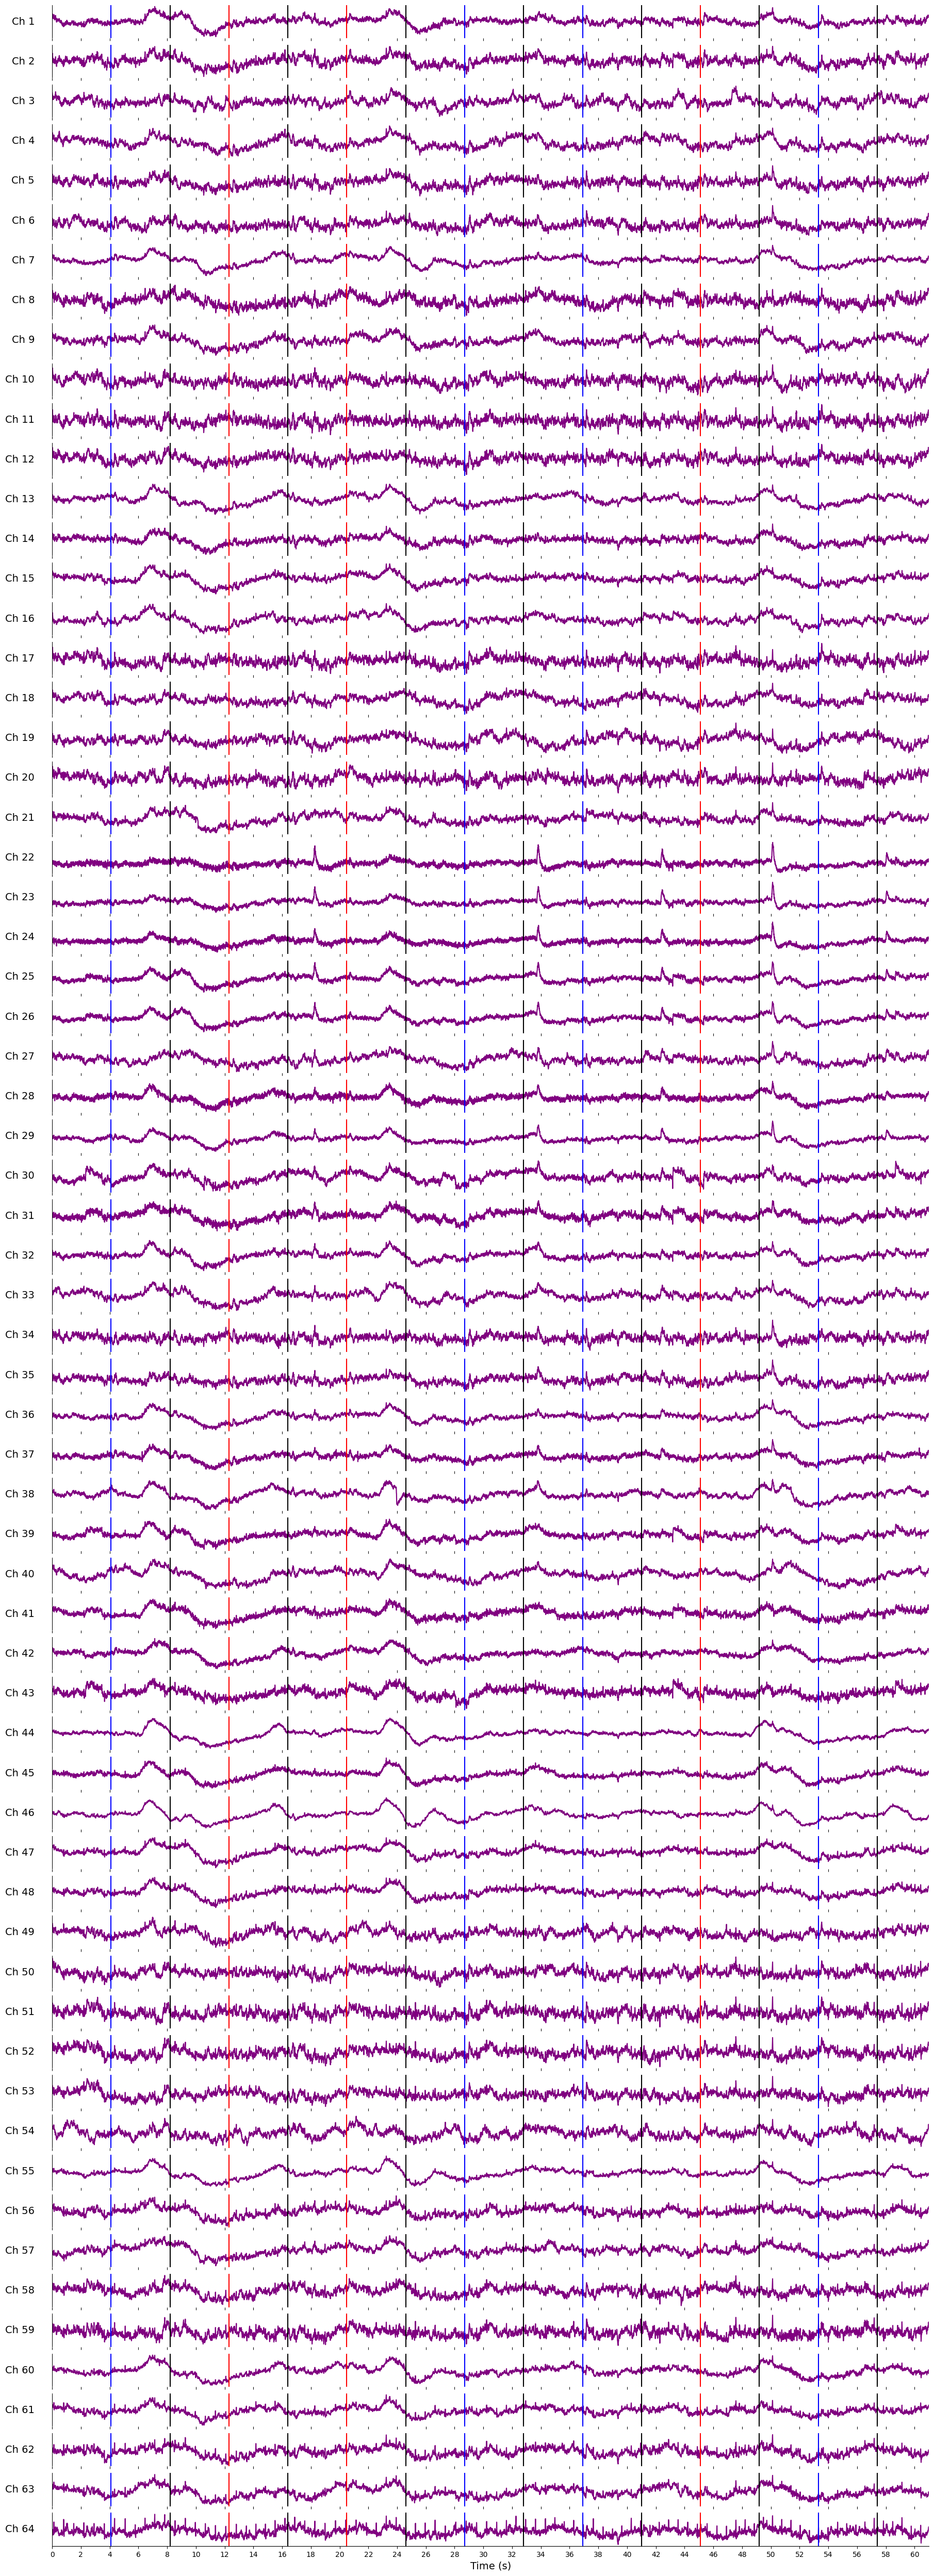

In [63]:
data, signal_headers, header = auxlib.loadEEG(subject=10, record=3, path_files=path_files)

time = np.linspace(0, len(data[0])/160, len(data[0]))
fig = showEEG(data, 0, 9760, time, range(64))

<h2>Labeling</h2>

In [64]:
def task_labels(header):
	t0_labels = []
	t1_labels = []
	t2_labels = []
	for task in range(len(header['annotations'])):
		if header['annotations'][task][2] == 'T1':
			t1_labels.append(header['annotations'][task][0])
		elif header['annotations'][task][2] == 'T2':
			t2_labels.append(header['annotations'][task][0])
		else:
			t0_labels.append(header['annotations'][task][0])
	return t0_labels, t1_labels, t2_labels

<h2>Power Density</h2>

In [65]:
# Power Density Spectrum Porcentual
# Parameters
# x: Signal to convert
# fs: sample frequency
# nfft: fft length, padded with 0
# Outputs
# Psd_per: Power Spectarl Density in %, the sum of all vector is 1 (is equal to integrate 0 - fs/2)
# Pxx: Power Spectral Density
# X: FFT mod of x
# f: frequency scale.
# ----- TEST

def psd_percentage(x, fs, nfft):

    N = nfft
    X = abs(fft(x, n=nfft))/N
    Pxx = X**2
    X = X[0:int(N/2)+1]
    X[1:int(N/2)] = 2*X[1:int(N/2)] # duplicate except 0

    Pxx = Pxx[0:int(N/2)+1]
    #Pxx[1:int(N/2)] = 2*X[1:int(N/2)] # duplicate except 0 <- Bug

    Pxx[1:int(N/2)] = 2*Pxx[1:int(N/2)]

    Psd = (1/fs*N)*abs(fft(x, n=nfft))**2
    Psd = Psd[0:int(N/2)+1]
    Psd[1:int(N/2)] = 2*Psd[1:int(N/2)] # duplicate except 0

    f, S = scipy.signal.periodogram(x, fs,  nfft=nfft, scaling='spectrum')

    #psd_sum = sum(Psd)

    #Psd_per= Psd/psd_sum

    #Psd_per= (nfft/fs)*(Psd/psd_sum)

    #f = (fs/N)*np.arange(0, int(N/2)+1, 1) = S

    Psd_per = S

    f_dif = f[1]-f[0]

    psd_sum = sum(Psd_per) * f_dif

    Psd_per= Psd_per/psd_sum

    return Psd_per, Pxx, X, f

<h2>Filter</h2>

In [66]:
# Filter Notch Design
#----------------------------------------------------------------
# Parameters
# data: data to be filtered
# f0: frequency to filter
# Q: Filter Quality Factor, Range Values 1-100, Typical 30-40
# fs: Sample frequency
#
# Output
# array filtrated signal


def notch_filter(data, f0, Q, fs):
    # IIR notch filter using signal.iirnotch
    b, a = signal.iirnotch(f0, Q, fs)

    # Compute magnitude response of the designed filter
    freq, h = signal.freqz(b, a, fs=fs)

    return signal.filtfilt(b, a, data)



In [67]:
# narrow band filters

# data: fato to be filtered
# lowcut: left frequency limit
# highcut: right frequency limit
# fs: Sample frequency

def narrow_bandpass_filter(data, lowcut, highcut, fs, order=4):

    butter_filter = signal.butter(N=4, Wn=[lowcut, highcut], output='sos', fs=fs, btype='bandpass')

    return signal.sosfiltfilt(butter_filter, data)

In [68]:
# Function description:
# Denoising signal for each channel (1-64) extracting f0
# ---------------------------------------------------------------------------------
# Parameters
# sessions: Patient / Subject / Animal - Ej: sessions = [50]
# tasks: array of expermient runs R3, R4, ... R14.
# Examples tasks = [3, 7, 11], tasks = [4, 8, 12], tasks = [5, 8, 13] , [6, 10, 14]
# f0: frequency to filter
# Q: Filter Quality Factor, Range Values 1-100, Typical 30-40
# fs: Sample frequency
#
# Output
# array filtrated signal - 64 eeg channels , signal length 125 sec x 160

# transpose Matrix to save .csv (Revise)

def denoising_notch(session, task, f0, Q, fs):

    data, signal_headers, header = auxlib.loadEEG(subject=session, record=task, path_files=path_files)
    t0_labels, t1_labels, t2_labels = task_labels(header)
    time = np.linspace(0, len(data[0])/160, len(data[0]))

    # filtering noise
    for i in range(0, data.shape[0]):
        data[i] = notch_filter(data[i], f0=60, Q=30, fs=160)

        # Save Data
        #data_t = np.transpose(data)
        #pd.DataFrame(data_t, ).to_csv(f'media/S{session:03d}R{run:02d}_denoised_{f0}_Hz.csv')

    return data, t0_labels, t1_labels, t2_labels

<h2>Labels</h2>
<p>Each annotation includes one of three codes (T0, T1, or T2):</p>
<ul>
    <li>T0 corresponds to rest</li>
    <li>T1 corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)</li>
    <li>T2 corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)</li>
</ul>
<p>Task Runs</p>
<ul>
    <li>Left or Right Hand Real: R3, R7, R11</li>
    <li>Left or Right Hand Imag: R4, R8, R12</li>
    <li>Both Hands or Both Feet Real: R5, R9, R13</li>
    <li>Both Hands or Both Feet Imag: R6, R10, R14</li>
<ul>

In [69]:
#Task Segementation / Fragmentations
# Description: Create segments for each T
# Parameters:
# data : data of all channels for specific session/patient, run number (3 = R3, 4 = R4, etc)
# dimensions: array[channels (64), total experiment samples (20000)]
# channel: signal channel, dimensions: scalar
# t0_labels, t1_labels, t2_labels: event labels, dimensions: array[7 or 8 or 15,] (depending repetitions)
# t_left: time left (time in seconds before event t1, or t2), dimensions: scalar
# t_right: time right (time in seconds after event t1, or t2), dimensions: scalar


def task_fragmentation(data, channel, t0_labels, t1_labels, t2_labels, t_left, t_right):
    data_t0 = []
    data_t1 = []
    data_t2 = []

    for i in range(len(t0_labels)):
        t0_index = int(t0_labels[i]*160)
        delta = int(4.1*160)
        t0_segment = data[channel, t0_index: t0_index+delta]
        data_t0.append(t0_segment)
    data_t0 = np.array(data_t0)


    for j in range(len(t1_labels)):
        t1_index = int(t1_labels[j]*160)
        delta_left = int(t_left*160)
        delta_right = int(t_right*160)
        t1_segment = data[channel, t1_index-delta_left: t1_index+delta_right]
        data_t1.append(t1_segment)
    data_t1 = np.array(data_t1)

    for k in range(len(t2_labels)):
        t2_index  = int(t2_labels[k]*160)
        delta_left = int(t_left*160)
        delta_right = int(t_right*160)
        t2_segment = data[channel, t2_index-delta_left: t2_index+delta_right]
        data_t2.append(t2_segment)
    data_t2 = np.array(data_t2)

    return data_t0, data_t1, data_t2

<h2>Power and Spectral Averages</h2>

In [70]:
# PSD Average for data divided in segments for a channel
# Parameters:
# data_segments: data segments for a specific session/patient, run number (3 = R3, 4 = R4, etc)
# and task (t1 LH, t2 RH, etc ) -  dimension: array[8 or 7 (segments), (t_left-t_right)*fs] (array of segments)
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_per_average/Np: Power density average in % - dimensions: array[nfft,]
# X_aver/Np: FFT mod average - dimensions: array[nfft,]
# f: frequency scale - dimensions: array[nfft,]
# Note: Run previously: data_t0, data_t1, data_t2= task_fragmentation(data, channel, t0_labels, t1_labels, t2_labels, t_left, t_right)


def segments_average(data_segments, fs, nfft):
    Np = data_segments.shape[0]
    Psd_per_average, Pxx, X_aver, f = psd_percentage(data_segments[0], fs, nfft)
    for i in range(Np-1):
        Psd_per, Pxx, X_aver_n, f = psd_percentage(data_segments[i+1], fs, nfft)
        Psd_per_average = Psd_per_average + Psd_per
        X_aver = X_aver + X_aver_n
    return Psd_per_average/Np, X_aver/Np , f


In [71]:
def segments_average_welch(data_segments, fs, nperseg, noverlap, nfft ):
    Np = data_segments.shape[0]
    Pxx_den, f = psd_welch(data_segments[0], fs, nperseg, noverlap, nfft)
    for i in range(Np-1):
        Pxx_den_i, f = psd_welch(data_segments[i+1], fs, nperseg, noverlap, nfft)
        Pxx_den = Pxx_den + Pxx_den_i
    return Pxx_den/Np , f

In [72]:
# PSD Average for each channel
# Parameters:
# data: data for a specific session/patient, run number (3 = R3, 4 = R4, etc) and task (t1 LH, t2 RH, etc )
# data dimensions: array[channles, allsamples] exmple [64, 20000]
# t0_labels, t1_labels, t2_labels: labels of data
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel: Power density average in % array[channels, nfft]
# X_aver/Np: FFT mod average
# f: frequency scale
# Note: Run: data, t0_labels, t1_labels, t2_labels = denoising_notch(session, task, f0, Q, fs)
# define t_left and t_right previsously


def psd_per_channels(data, t0_labels, t1_labels, t2_labels, fs, nfft):
        Psd_prom_t0_per_channel = []
        Psd_prom_t1_per_channel = []
        Psd_prom_t2_per_channel = []

        for i in range(data.shape[0]):
            data_t0, data_t1, data_t2 = task_fragmentation(data=data,channel=i,
                                                           t0_labels=t0_labels,
                                                           t1_labels=t1_labels,
                                                           t2_labels=t2_labels, t_left=t_left, t_right=t_right)
            Psd_prom_t0_channel, X_prom_t0_channel, f = segments_average(data_t0, fs=160, nfft=nfft)
            Psd_prom_t1_channel, X_prom_t1_channel, f = segments_average(data_t1, fs=160, nfft=nfft)
            Psd_prom_t2_channel, X_prom_t2_channel, f = segments_average(data_t2, fs=160, nfft=nfft)
            #Adding psd_prom for each channel for each t0, t1, t2
            Psd_prom_t0_per_channel.append(Psd_prom_t0_channel)
            Psd_prom_t1_per_channel.append(Psd_prom_t1_channel)
            Psd_prom_t2_per_channel.append(Psd_prom_t2_channel)

        Psd_prom_t0_per_channel = np.array(Psd_prom_t0_per_channel)
        Psd_prom_t1_per_channel = np.array(Psd_prom_t1_per_channel)
        Psd_prom_t2_per_channel = np.array(Psd_prom_t2_per_channel)

        return Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f

In [73]:
# Welch PSD Average for each channel
# Parameters:
# data: data for a specific session/patient, run number (3 = R3, 4 = R4, etc) and task (t1 LH, t2 RH, etc )
# data dimensions: array[channles, allsamples] exmple [64, 20000]
# t0_labels, t1_labels, t2_labels: labels of data
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel: Power density average in % array[channels, nfft]
# X_aver/Np: FFT mod average
# f: frequency scale
# Note: Run: data, t0_labels, t1_labels, t2_labels = denoising_notch(session, task, f0, Q, fs)
# define t_left and t_right previsously


def psd_per_channels_welch(data, t0_labels, t1_labels, t2_labels, fs, nperseg, noverlap, nfft):
        Psd_prom_t0_per_channel = []
        Psd_prom_t1_per_channel = []
        Psd_prom_t2_per_channel = []

        for i in range(data.shape[0]):
            data_t0, data_t1, data_t2 = task_fragmentation(data=data,channel=i,
                                                           t0_labels=t0_labels,
                                                           t1_labels=t1_labels,
                                                           t2_labels=t2_labels, t_left=t_left, t_right=t_right)
            Psd_prom_t0_channel, f = segments_average_welch(data_t0, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
            Psd_prom_t1_channel, f = segments_average_welch(data_t1, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
            Psd_prom_t2_channel, f = segments_average_welch(data_t2, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
            #Adding psd_prom for each channel for each t0, t1, t2
            Psd_prom_t0_per_channel.append(Psd_prom_t0_channel)
            Psd_prom_t1_per_channel.append(Psd_prom_t1_channel)
            Psd_prom_t2_per_channel.append(Psd_prom_t2_channel)

        Psd_prom_t0_per_channel = np.array(Psd_prom_t0_per_channel)
        Psd_prom_t1_per_channel = np.array(Psd_prom_t1_per_channel)
        Psd_prom_t2_per_channel = np.array(Psd_prom_t2_per_channel)

        return Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f

In [74]:
# PSD averages for set of runs/tasks
# Description: Averages psd for all runs in a vector, for a specific session
# Parameters:
# session: session number - dimensions scalar 1 - 100
# tasks: task array of runs - dimension array[taskquantity, ] , Example: [3, 7, 11] R3, R7 and R11
# fs:sample frequency
# nfft: fft length, padded with 0
# Outputs
# Psd_prom_t0_runs/len(tasks), Psd_prom_t1_runs/len(tasks), Psd_prom_t2_runs/len(tasks): Pds avergaes for runs/task
# for specific session - dimensions array[channels, nfft]
# f: frequency scale- dimension array[nfft,]




def psd_all_runs(session, tasks, fs, nfft):

        data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session,
                                                                 task=tasks[0],
                                                                 f0=60,
                                                                 Q=30,
                                                                 fs=160)
        Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f = psd_per_channels(data,
                                                                                                t0_labels=t0_labels,
                                                                                                t1_labels=t1_labels,
                                                                                                t2_labels=t2_labels,
                                                                                                fs=160, nfft=nfft)
        Psd_prom_t0_runs= Psd_prom_t0_per_channel
        Psd_prom_t1_runs= Psd_prom_t1_per_channel
        Psd_prom_t2_runs= Psd_prom_t2_per_channel

        for i in range(len(tasks)-1):
            data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session,
                                                                     task=tasks[i+1],
                                                                     f0=60,
                                                                     Q=30,
                                                                     fs=160)
            Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f = psd_per_channels(data=data,
                                                                                                    t0_labels=t0_labels,
                                                                                                    t1_labels=t1_labels,
                                                                                                    t2_labels=t2_labels,
                                                                                                    fs=160, nfft=nfft)
            Psd_prom_t0_runs= Psd_prom_t0_runs + Psd_prom_t0_per_channel
            Psd_prom_t1_runs= Psd_prom_t1_runs + Psd_prom_t1_per_channel
            Psd_prom_t2_runs= Psd_prom_t2_runs + Psd_prom_t2_per_channel

        return Psd_prom_t0_runs/len(tasks), Psd_prom_t1_runs/len(tasks), Psd_prom_t2_runs/len(tasks), f

In [75]:
def psd_all_sessions(sessions, tasks, fs, nfft):

    Psd_prom_t0_session, Psd_prom_t1_session, Psd_prom_t2_session, f = psd_all_runs(session=1, tasks=tasks, fs=160, nfft=nfft)

    for i in range(sessions-1):
        Psd_prom_t0_session_i,  Psd_prom_t1_session_i,  Psd_prom_t2_session_i, f = psd_all_runs(session=(i+1), tasks=tasks, fs=160, nfft=nfft)
        print("Solving session:")
        print(i+1)
        Psd_prom_t0_session = Psd_prom_t0_session +  Psd_prom_t0_session_i
        Psd_prom_t1_session = Psd_prom_t1_session +  Psd_prom_t1_session_i
        Psd_prom_t2_session = Psd_prom_t2_session +  Psd_prom_t2_session_i

    return  Psd_prom_t0_session/sessions, Psd_prom_t1_session/sessions, Psd_prom_t2_session/sessions, f


<h2>Plots</h2>

In [76]:
# Plot Psd for each segment and average, specific session, specific run, specific task

def plot_psd_per(data_segments, fs, nfft, band="alpha"):
    band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
    plt.figure()
    for i in range(data_segments.shape[0]):
        Psd_per, Pxx, X, f = psd_percentage(data_segments[i], fs, nfft=nfft)
        plt.plot(f, Psd_per)
        print(len(Psd_per))
        print(sum(Psd_per))
    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    print(sum(Psd_prom))
    plt.plot(f, Psd_prom,"k", linewidth=3)
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(f"Power Spectrum Density % - Session: {session}, Channel: {channel}, Run: {task}, Segments 1/{i+1}")
    plt.xlim(limits)
    plt.grid()
    plt.show()

def plot_psd_per_mean(data_segments, fs, nfft, band="alpha"):
    band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
    plt.figure()
    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    #print(sum(Psd_prom))
    plt.plot(f, Psd_prom, linewidth=3)
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(f"Power Spectrum Density % - Session: {session}, Channel: {channel}, Run: {task}")
    plt.xlim(limits)
    plt.grid()
    plt.show()

def plot_psd_per_compare(data_segments, data_segments2, fs, nfft, band="alpha"):
    band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
    plt.figure()
    for i in range(data_segments.shape[0]):
        Psd_per, Pxx, X, f = psd_percentage(data_segments[i], fs, nfft=nfft)
        Psd_per2, Pxx2, X2, f2 = psd_percentage(data_segments2[i], fs, nfft=nfft)
    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)
    #print(sum(Psd_prom))
    plt.plot(f, Psd_prom, linewidth=3, label=f"Run {task}")
    plt.plot(f, Psd_prom2, linewidth=3, label=f"Run {task+1}")
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(f"Power Spectrum Density % - Session: {session}, Channel: {channel}, Runs: {task} and {task+1}")
    plt.xlim(limits)
    plt.legend()
    plt.grid()
    plt.show()

In [77]:
# Plot Welch Psd for each segment and average, specific session, specific run, specific task

def plot_psd_per_welch(data_segments, fs, nperseg, noverlap, nfft):
    plt.figure()
    for i in range(data_segments.shape[0]):
        Psd_seg_welch, f = psd_welch(data_segments[i], fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        plt.plot(f, Psd_seg_welch)
        print(len(Psd_seg_welch))
        print(sum(Psd_seg_welch))
    Psd_prom_welch, f = segments_average_welch(data_segments, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    print(sum(Psd_prom_welch))
    plt.plot(f, Psd_prom_welch,"k", linewidth=3)
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(f"Power Spectrum Welch Density % - Session: {session}, Channel: {channel}, Run: {task}, Segments 1/{i+1}")
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

In [78]:
# Plot Mod FFT for each segment and average, specific session, specific run, specific task

def plot_mod_fft(data_segments, fs, nfft):
    plt.figure()
    for i in range(data_segments.shape[0]):
        Psd_per, Pxx, X, f = psd_percentage(data_segments[i], fs, nfft=nfft)
        plt.plot(f, X)
        print(len(Psd_per))
        print(sum(Psd_per))
    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    print(sum(Psd_prom))
    plt.plot(f, X_prom,"k", linewidth=3)
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(f"Mod FFT Spectrum - Session: {session}, Channel: {channel}, Run: {task}, Segments 1/{i+1}")
    plt.xlim(0, 10)
    plt.grid()
    plt.show()

In [79]:
def plot_segments(data_segments, fs):
    plt.figure()
    for i in range(data_segments.shape[0]):
        Psd_per, Pxx, X, f = psd_percentage(data_segments[i], fs, nfft=nfft)
        plt.plot(data_segments[i])

    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f"Segments Amplitud in Time")
    plt.xlim(0, 1200)
    plt.grid()
    plt.show()


# Análisis

In [80]:
#session = 1
session = 10
task = 3
channel = 22
fs = 160
nfft =  8192
#nperseg = 1024
#noverlap = 256

In [81]:
t_left = 1
t_right = 3

In [82]:
data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)

## Banda alfa

In [83]:
lowcut = 8
highcut = 14

In [84]:
data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

In [85]:
data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

In [86]:
data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                               t0_labels=t0_labels,
                                               t1_labels=t1_labels,
                                               t2_labels=t2_labels,
                                               t_left=t_left,
                                               t_right=t_right)

data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                               t0_labels=t0_labels2,
                                               t1_labels=t1_labels2,
                                               t2_labels=t2_labels2,
                                               t_left=t_left,
                                               t_right=t_right)

4097
51.19999999999979
4097
51.20000000000014
4097
51.19999999999996
4097
51.20000000000017
4097
51.20000000000011
4097
51.20000000000015
4097
51.20000000000046
4097
51.19999999999997
51.19999999999991


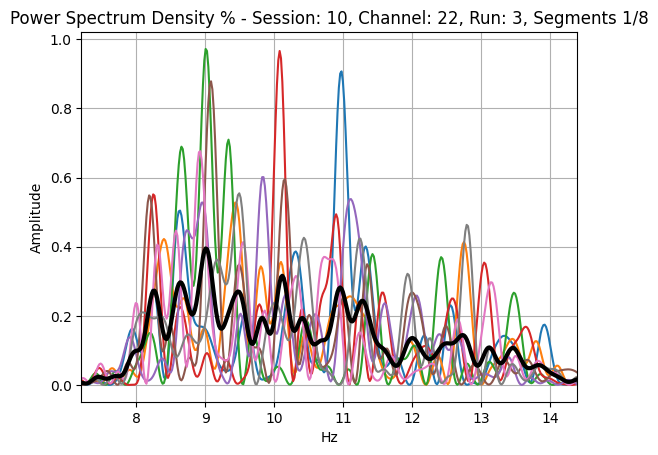

In [87]:
plot_psd_per(data_t1, fs, nfft)

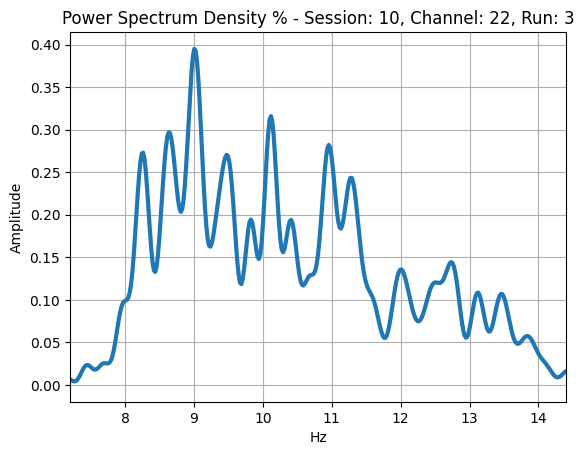

In [88]:
plot_psd_per_mean(data_t1, fs, nfft)

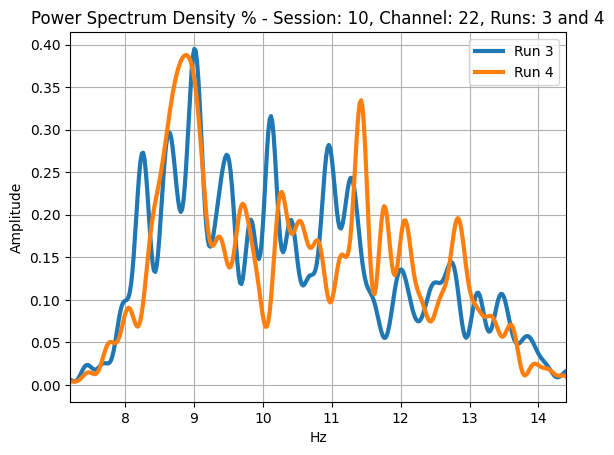

In [89]:
plot_psd_per_compare(data_t1, data_t12, fs, nfft)

### Diferencias

In [90]:
data_segments = data_t1
data_segments2 = data_t12

Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

In [91]:
differences = (Psd_prom - Psd_prom2)**2

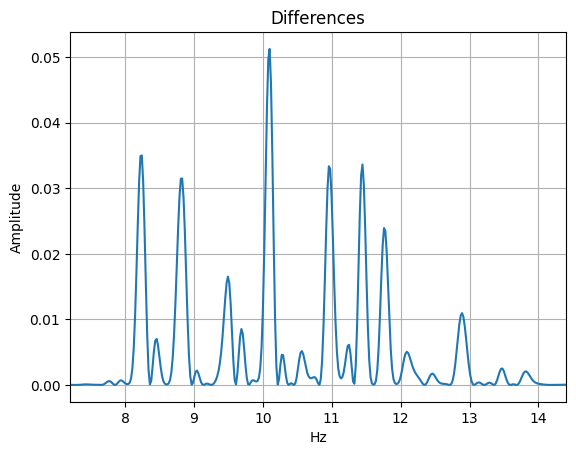

In [92]:
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))

plt.figure()
plt.plot(f, differences)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences")
plt.xlim(limits)
plt.grid()
plt.show()

## Comparando mismo canal con sujetos diferentes

In [93]:
tot = []

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


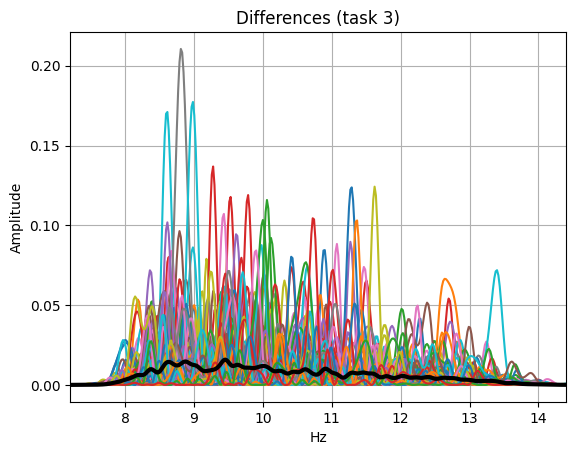

In [94]:
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 3

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


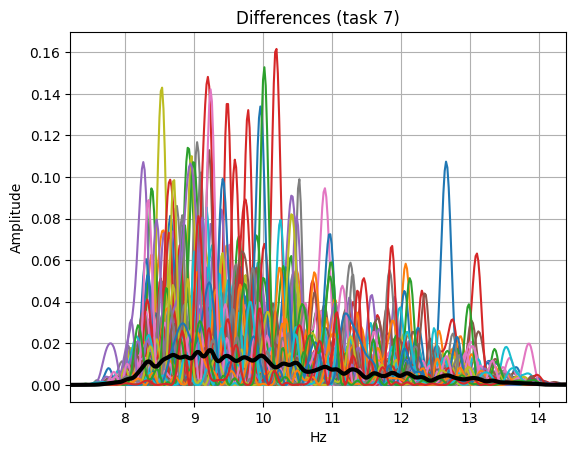

In [95]:
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 7

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


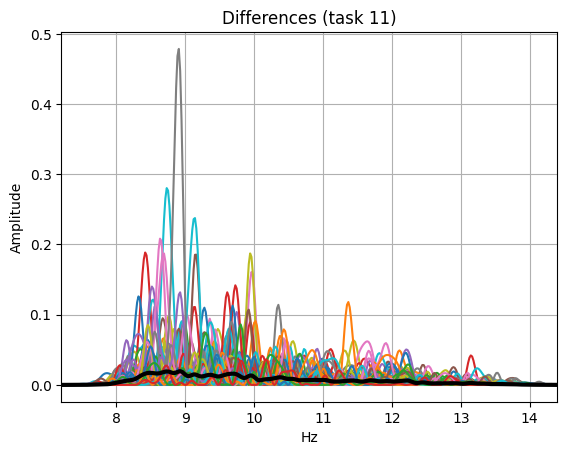

In [96]:
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 11

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()

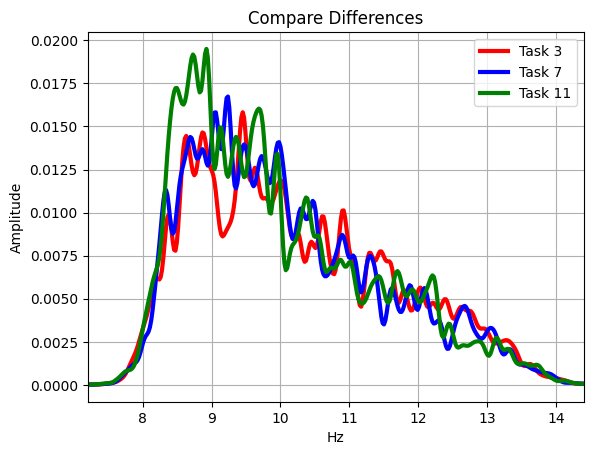

In [97]:
plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences.png", dpi=300)
plt.show()

# 5, 9, 13

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


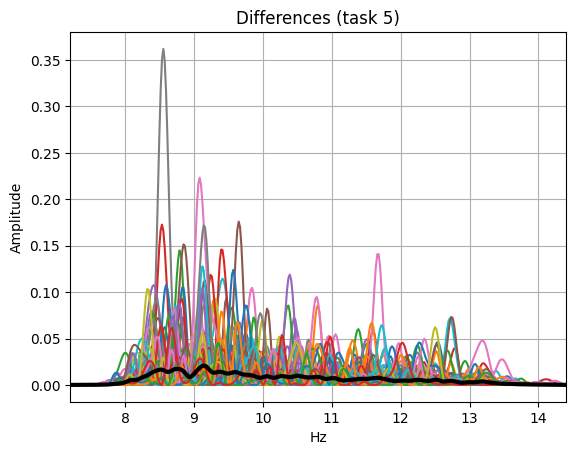

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


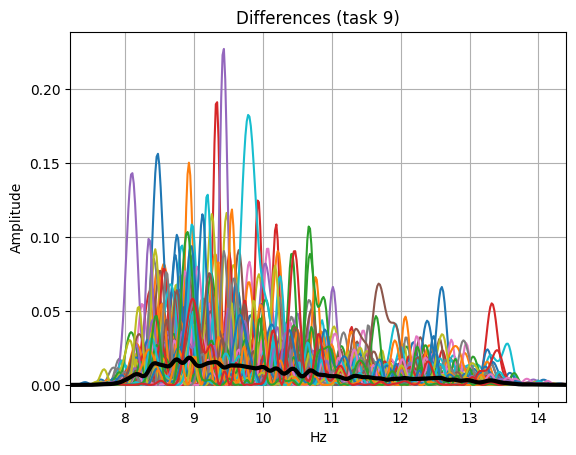

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


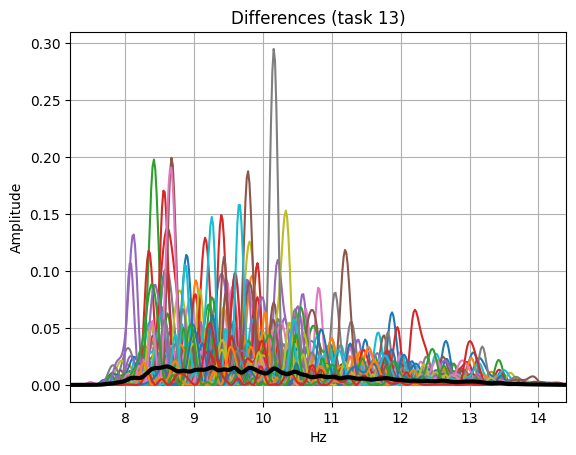

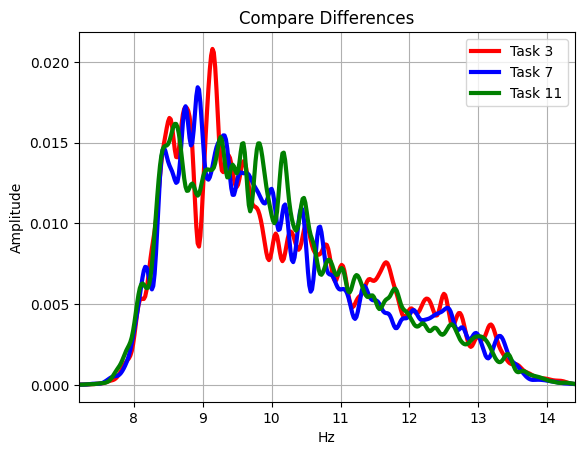

In [98]:
tot = []
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 5

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 9

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "alpha"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
dif_vector = []

task = 13

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}.png", dpi=300)
plt.show()
plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_BH_BF.png", dpi=300)
plt.show()

# theta

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


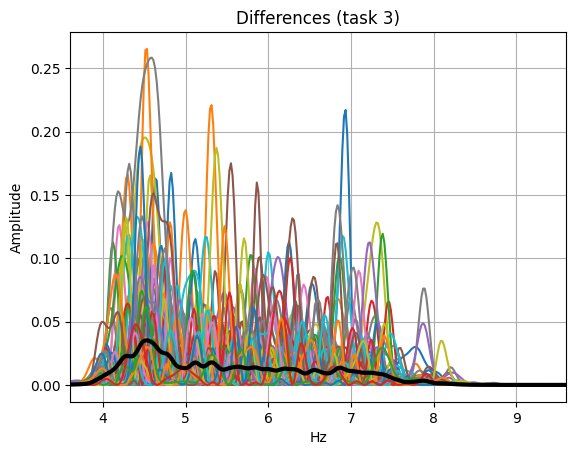

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


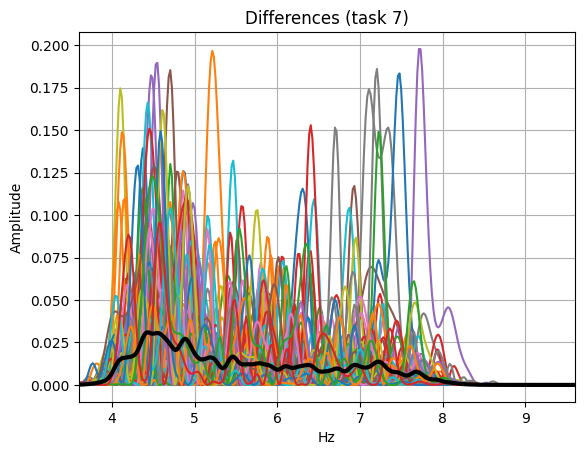

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


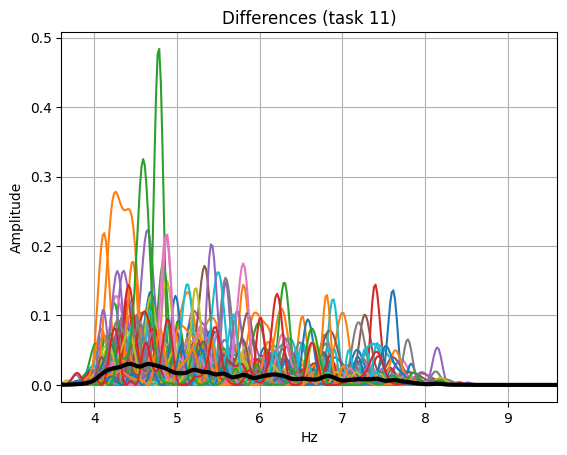

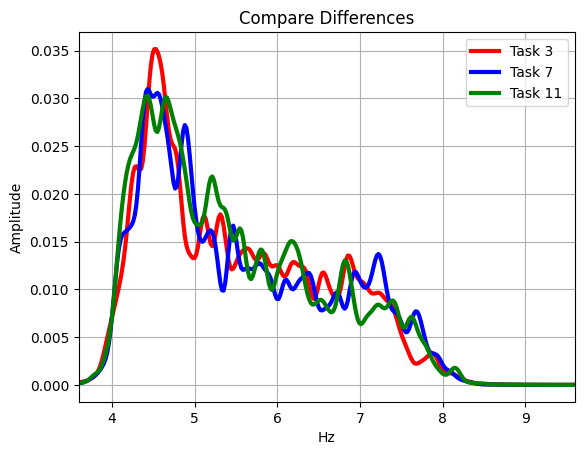

In [100]:
tot = []
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "theta"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
lowcut = band_dict[band][0]
highcut = band_dict[band][1]
dif_vector = []

task = 3

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 7

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 11

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()
plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_{band}.png", dpi=300)
plt.show()

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


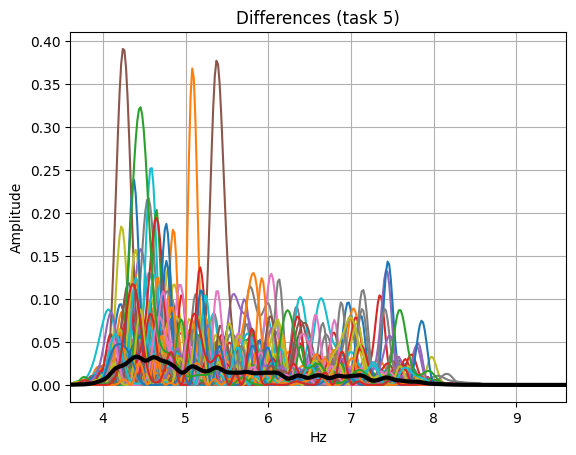

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


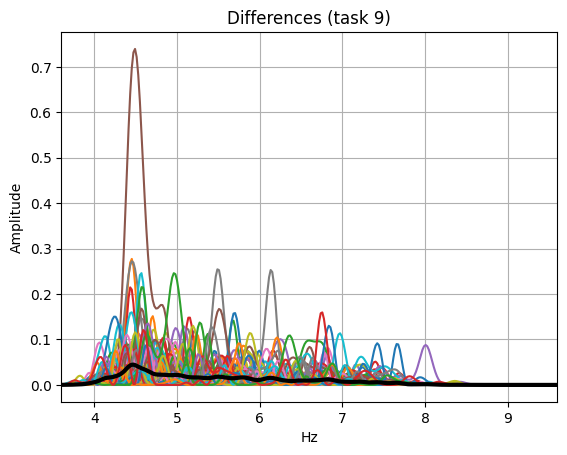

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


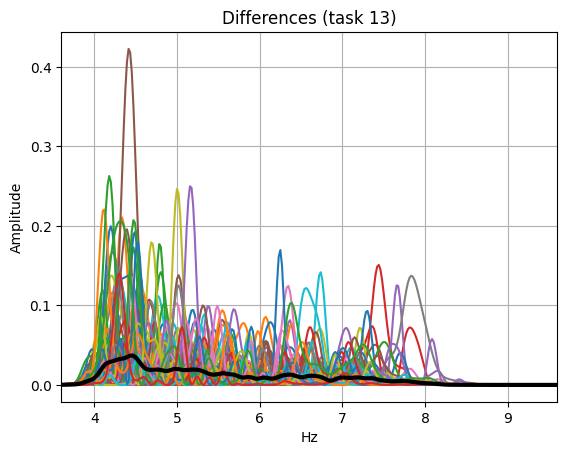

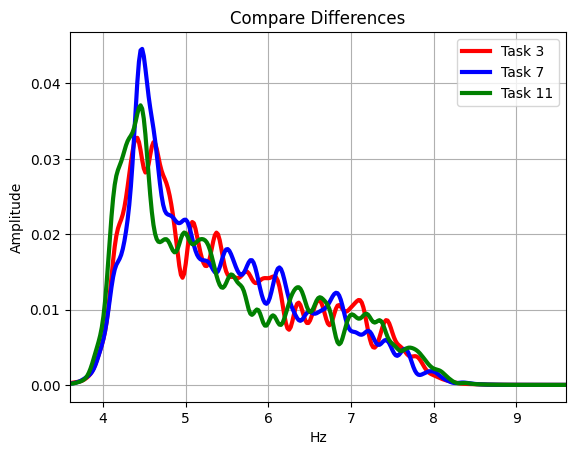

In [101]:
tot = []
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "theta"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
lowcut = band_dict[band][0]
highcut = band_dict[band][1]
dif_vector = []

task = 5

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 9

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 13

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()
plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_BH_BF_{band}.png", dpi=300)
plt.show()

# delta

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


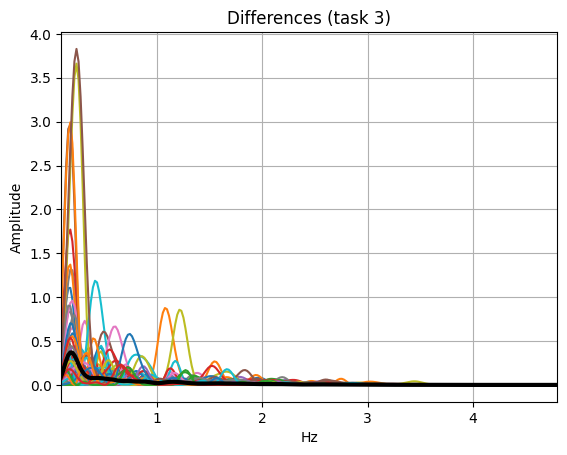

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


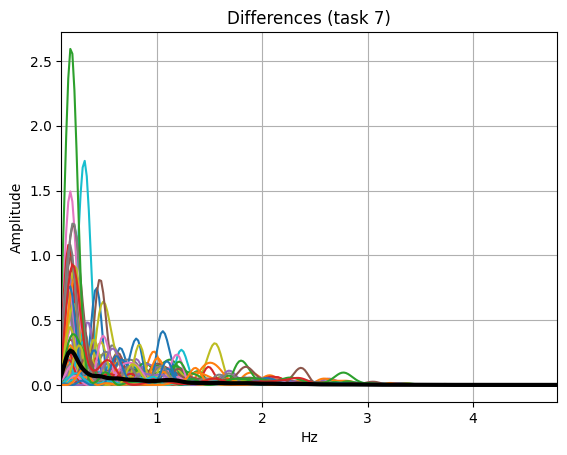

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


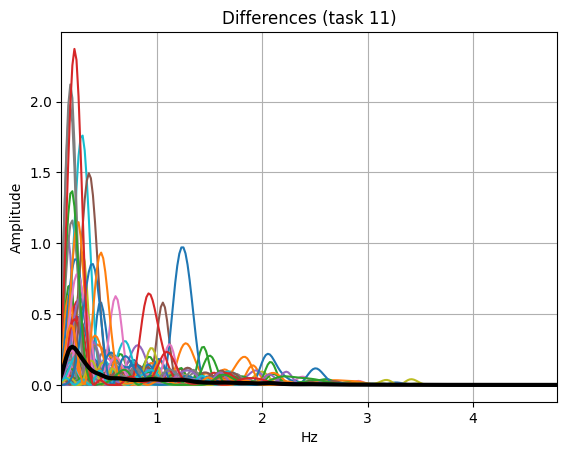

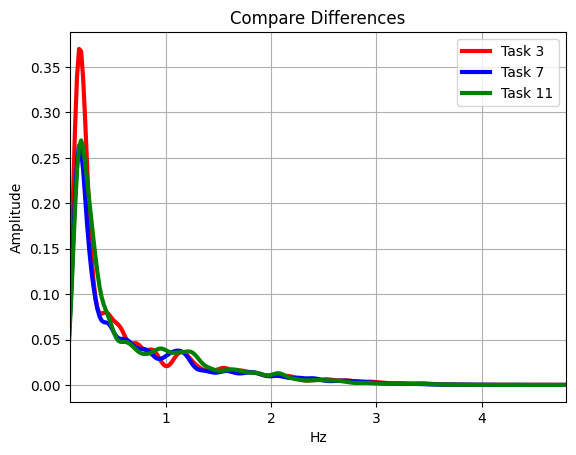

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


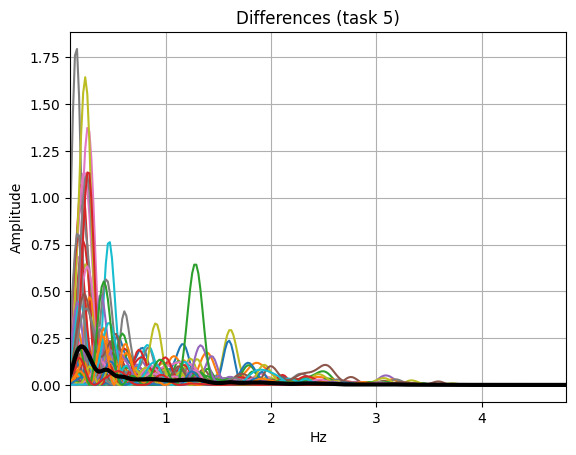

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


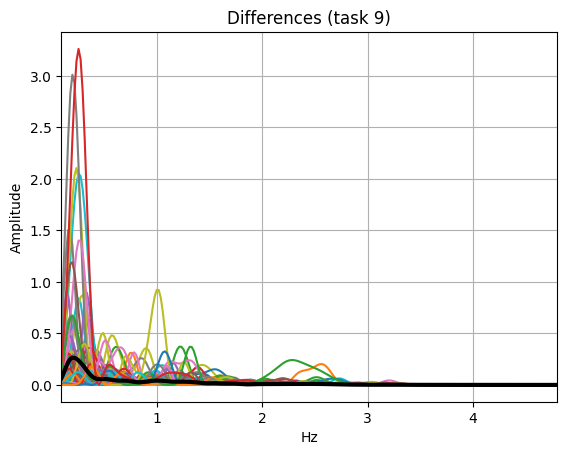

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


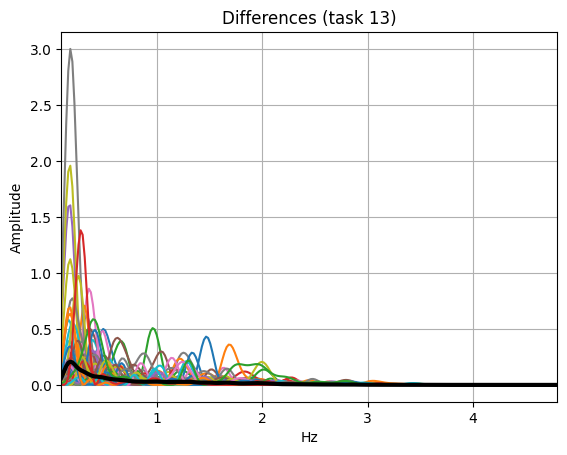

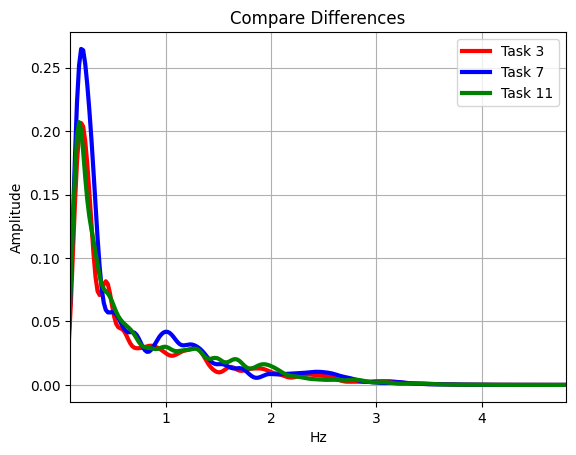

In [102]:
tot = []
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "delta"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
lowcut = band_dict[band][0]
highcut = band_dict[band][1]
dif_vector = []

task = 3

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()


dif_vector = []

task = 7

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 11

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_{band}.png", dpi=300)
plt.show()

tot = []

dif_vector = []

task = 5

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 9

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()


dif_vector = []

task = 13

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()


plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_BH_BF_{band}.png", dpi=300)
plt.show()

# beta

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


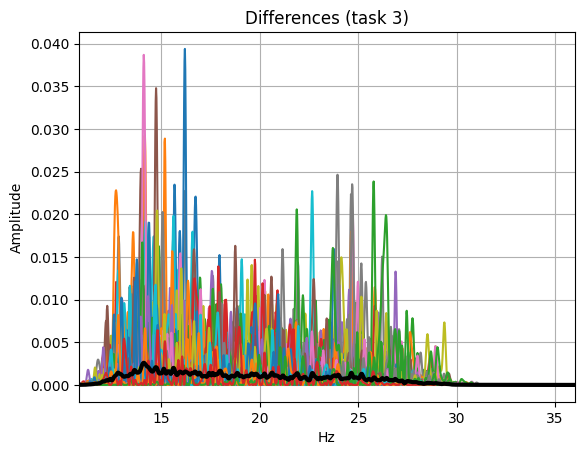

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


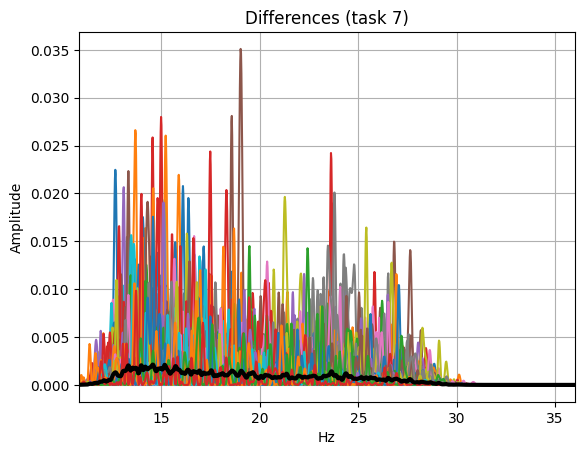

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


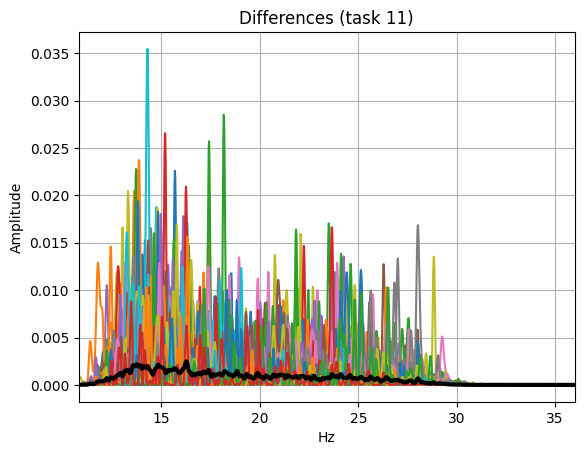

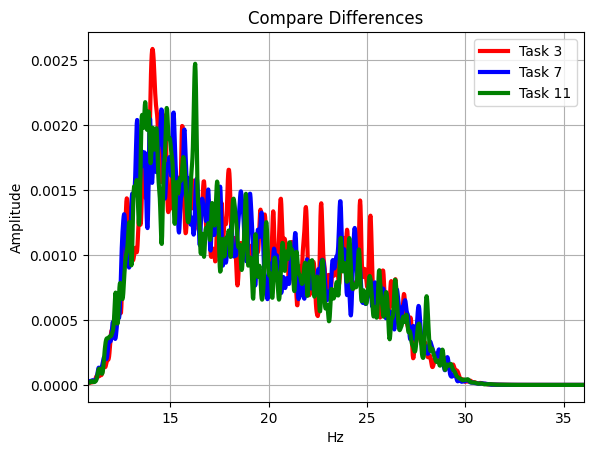

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


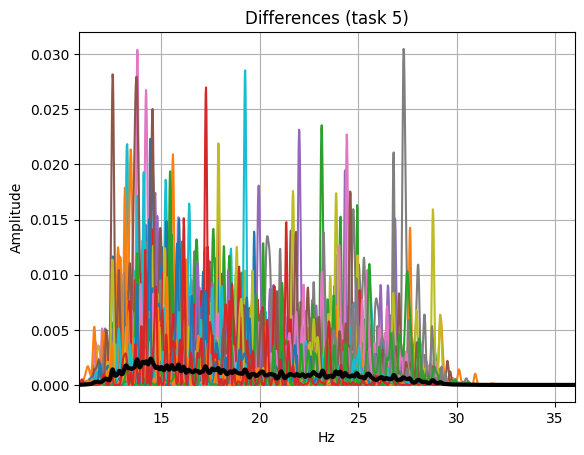

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


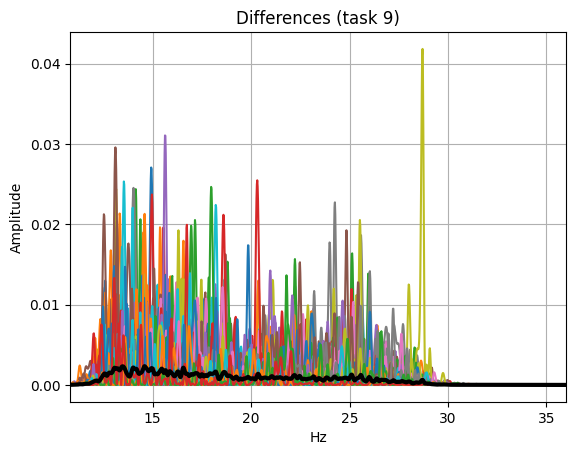

Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7
Session: 8
Session: 9
Session: 10
Session: 11
Session: 12
Session: 13
Session: 14
Session: 15
Session: 16
Session: 17
Session: 18
Session: 19
Session: 20
Session: 21
Session: 22
Session: 23
Session: 24
Session: 25
Session: 26
Session: 27
Session: 28
Session: 29
Session: 30
Session: 31
Session: 32
Session: 33
Session: 34
Session: 35
Session: 36
Session: 37
Session: 38
Session: 39
Session: 40
Session: 41
Session: 42
Session: 43
Session: 44
Session: 45
Session: 46
Session: 47
Session: 48
Session: 49
Session: 50
Session: 51
Session: 52
Session: 53
Session: 54
Session: 55
Session: 56
Session: 57
Session: 58
Session: 59
Session: 60
Session: 61
Session: 62
Session: 63
Session: 64
Session: 65
Session: 66
Session: 67
Session: 68
Session: 69
Session: 70
Session: 71
Session: 72
Session: 73
Session: 74
Session: 75
Session: 76
Session: 77
Session: 78
Session: 79
Session: 80
Session: 81
Session: 82
Session: 83
Session: 84


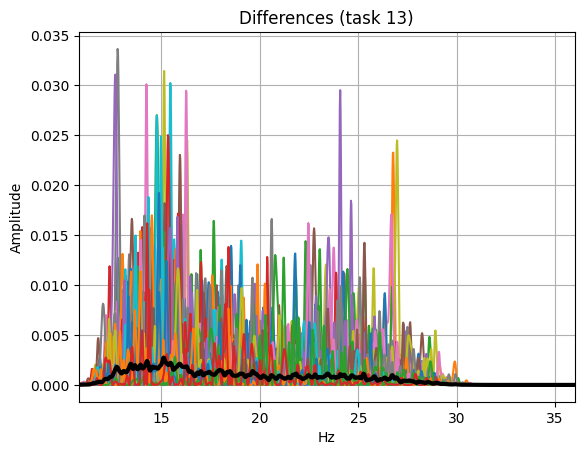

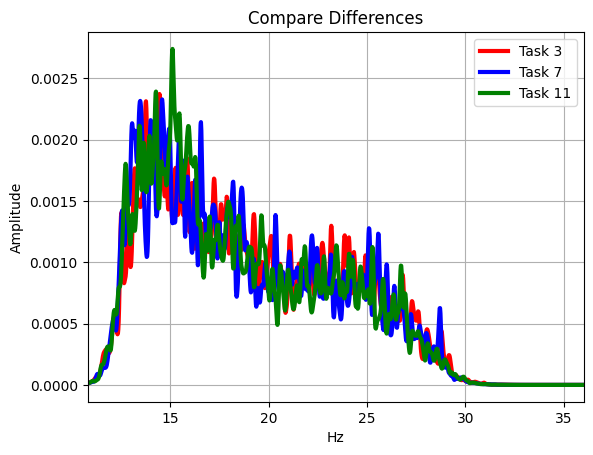

In [103]:
tot = []
#sujetos = [10, 20, 29]
sujetos = [i for i in range(1, 85)]
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
band = "beta"
limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
lowcut = band_dict[band][0]
highcut = band_dict[band][1]
dif_vector = []

task = 3

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 7

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()


dif_vector = []

task = 11

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_{band}.png", dpi=300)
plt.show()

tot = []

dif_vector = []

task = 5

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)


plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 9

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

dif_vector = []

task = 13

plt.figure()
for i in range(len(sujetos)):
    session = sujetos[i]
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)
    data2, t0_labels2, t1_labels2, t2_labels2  = denoising_notch(session=session, task=task+1, f0=60, Q=30, fs=160)

    data = narrow_bandpass_filter(data, lowcut, highcut, fs, order=4)
    data2 = narrow_bandpass_filter(data2, lowcut, highcut, fs, order=4)

    data_t0, data_t1, data_t2 = task_fragmentation(data=data, channel = channel,
                                                t0_labels=t0_labels,
                                                t1_labels=t1_labels,
                                                t2_labels=t2_labels,
                                                t_left=t_left,
                                                t_right=t_right)

    data_t02, data_t12, data_t22 = task_fragmentation(data=data2, channel = channel,
                                                t0_labels=t0_labels2,
                                                t1_labels=t1_labels2,
                                                t2_labels=t2_labels2,
                                                t_left=t_left,
                                                t_right=t_right)

    data_segments = data_t1
    data_segments2 = data_t12

    Psd_prom, X_prom, f = segments_average(data_segments, fs=160, nfft = nfft)
    Psd_prom2, X_prom2, f = segments_average(data_segments2, fs=160, nfft = nfft)

    differences = (Psd_prom - Psd_prom2)**2
    dif_vector.append(differences)

    plt.plot(f, differences)
    print(f"Session: {session}")

total_dif = np.mean(dif_vector, axis=0)
tot.append(total_dif)

plt.plot(f, total_dif, "k", linewidth=3)
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Differences (task {task})")
plt.xlim(limits)
plt.grid()
plt.savefig(f"media/differences_task{task}_{band}.png", dpi=300)
plt.show()

plt.plot(f, tot[0], linewidth=3, color='r', label=f"Task 3")
plt.plot(f, tot[1], linewidth=3, color='b', label=f"Task 7")
plt.plot(f, tot[2], linewidth=3, color='g', label=f"Task 11")
plt.xlabel('Hz')
plt.ylabel('Amplitude')
plt.title(f"Compare Differences")
plt.xlim(limits)
plt.legend()
plt.grid()
plt.savefig(f"media/compare_differences_BH_BF_{band}.png", dpi=300)
plt.show()